In [57]:
# import libraries
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from pandas import json_normalize
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression  # For building the regression model
from sklearn.metrics import mean_squared_error, r2_score  # For evaluating the model
import statsmodels.api as sm  # For statistical modeling and hypothesis testing (optional)


In [58]:
# Load in the provided train and test csv files
train_df = pd.read_csv('/Users/blairjdaniel/kaggle_comps/kaggle_predict_podcast/files/train.csv')
test_df = pd.read_csv('/Users/blairjdaniel/kaggle_comps/kaggle_predict_podcast/files/test.csv')

In [59]:
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [60]:
# Look at the data, check for NaN values, anything funny
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


The cols to investigate are Episode_Length_minutes, Guest_Popularity_percentage, and Number_of_Ads but first lets clean up the col names to lower case.
We also need to change the pub_date and time to deltatime so that we can see if a certain day or time of day affects listening time.
My guess is that ep length, host popularity, pub day and time, guest popularity, genre will be the best coeffificients to listening time.

In [61]:
train_df = train_df.rename(columns={
    'Podcast_Name': 'podcast_name',
    'Episode_Title': 'episode_title',
    'Episode_Length_minutes': 'episode_length_minutes',
    'Genre': 'genre',
    'Host_Popularity_percentage': 'host_popularity_percentage',
    'Publication_Day': 'publication_day',
    'Publication_Time': 'publication_time',
    'Guest_Popularity_percentage': 'guest_popularity_percentage',
    'Number_of_Ads': 'number_of_ads',
    'Episode_Sentiment': 'episode_sentiment',
    'Listening_Time_minutes': 'listening_time_minutes'
    })
test_df = test_df.rename(columns={
    'Podcast_Name': 'podcast_name',
    'Episode_Title': 'episode_title',
    'Episode_Length_minutes': 'episode_length_minutes',
    'Genre': 'genre',
    'Host_Popularity_percentage': 'host_popularity_percentage',
    'Publication_Day': 'publication_day',
    'Publication_Time': 'publication_time',
    'Guest_Popularity_percentage': 'guest_popularity_percentage',
    'Number_of_Ads': 'number_of_ads',
    'Episode_Sentiment': 'episode_sentiment',
    'Listening_Time_minutes': 'listening_time_minutes'
    })

Look at episode length, see if the null values have a relationship with the podcast name to find the mean

In [62]:
# Find the podcast names missing values
missing_ep_min = train_df[train_df['episode_length_minutes'].isna()][['episode_length_minutes', 'podcast_name']]
missing_ep_min_test = test_df[test_df['episode_length_minutes'].isna()][['episode_length_minutes', 'podcast_name']]

In [63]:
# Group by 'podcast_name' and calculate the mean for numeric columns
fill_ep_length_nan = train_df.groupby(by='podcast_name').mean(numeric_only=True)
# Use the group mean for episode_length_minutes to create a mapping
mean_ep_length = fill_ep_length_nan['episode_length_minutes']

# Fill NaN values in the train_df using the mapping based on podcast_name
train_df.loc[train_df['episode_length_minutes'].isna(), 'episode_length_minutes'] = \
    train_df.loc[train_df['episode_length_minutes'].isna(), 'podcast_name'].map(mean_ep_length)

# Optionally, check that there are no more missing values in episode_length_minutes
train_df['episode_length_minutes'].isna().sum()

0

In [64]:
# Group by 'podcast_name' and calculate the mean for numeric columns
fill_ep_length_nan = test_df.groupby(by='podcast_name').mean(numeric_only=True)
# Use the group mean for episode_length_minutes to create a mapping
mean_ep_length = fill_ep_length_nan['episode_length_minutes']

# Fill NaN values in the test_df using the mapping based on podcast_name
test_df.loc[test_df['episode_length_minutes'].isna(), 'episode_length_minutes'] = \
    test_df.loc[test_df['episode_length_minutes'].isna(), 'podcast_name'].map(mean_ep_length)

# Optionally, check that there are no more missing values in episode_length_minutes
test_df['episode_length_minutes'].isna().sum()

0

In [65]:
# Group by 'podcast_name' and calculate the mean guest popularity percentage
fill_guest_pop = train_df.groupby(by='podcast_name').mean(numeric_only=True)
mean_guest_pop = fill_guest_pop['guest_popularity_percentage']

# Fill missing values in guest_popularity_percentage using the mapping
train_df.loc[train_df['guest_popularity_percentage'].isna(), 'guest_popularity_percentage'] = \
    train_df.loc[train_df['guest_popularity_percentage'].isna(), 'podcast_name'].map(mean_guest_pop)

# Optionally check for any remaining NaN values
train_df['guest_popularity_percentage'].isna().sum()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   podcast_name                 750000 non-null  object 
 2   episode_title                750000 non-null  object 
 3   episode_length_minutes       750000 non-null  float64
 4   genre                        750000 non-null  object 
 5   host_popularity_percentage   750000 non-null  float64
 6   publication_day              750000 non-null  object 
 7   publication_time             750000 non-null  object 
 8   guest_popularity_percentage  750000 non-null  float64
 9   number_of_ads                749999 non-null  float64
 10  episode_sentiment            750000 non-null  object 
 11  listening_time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [66]:
# Group by 'podcast_name' and calculate the mean guest popularity percentage
fill_guest_pop = test_df.groupby(by='podcast_name').mean(numeric_only=True)
mean_guest_pop = fill_guest_pop['guest_popularity_percentage']

# Fill missing values in guest_popularity_percentage using the mapping
test_df.loc[test_df['guest_popularity_percentage'].isna(), 'guest_popularity_percentage'] = \
    test_df.loc[test_df['guest_popularity_percentage'].isna(), 'podcast_name'].map(mean_guest_pop)

# Optionally check for any remaining NaN values
test_df['guest_popularity_percentage'].isna().sum()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           250000 non-null  int64  
 1   podcast_name                 250000 non-null  object 
 2   episode_title                250000 non-null  object 
 3   episode_length_minutes       250000 non-null  float64
 4   genre                        250000 non-null  object 
 5   host_popularity_percentage   250000 non-null  float64
 6   publication_day              250000 non-null  object 
 7   publication_time             250000 non-null  object 
 8   guest_popularity_percentage  250000 non-null  float64
 9   number_of_ads                250000 non-null  float64
 10  episode_sentiment            250000 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 21.0+ MB


In [67]:
# Fill the missing value in the number of ads with the mean
mean_ads = train_df['number_of_ads'].mean()

# Fill the missing value in the number_of_ads column with the calculated mean
train_df['number_of_ads'].fillna(mean_ads, inplace=True)

# Verify the missing value is filled
train_df['number_of_ads'].isna().sum()
train_df.info()

/var/folders/2m/_3np4g752dzdn21lzc5c7nsm0000gn/T/ipykernel_9369/3654618239.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['number_of_ads'].fillna(mean_ads, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   podcast_name                 750000 non-null  object 
 2   episode_title                750000 non-null  object 
 3   episode_length_minutes       750000 non-null  float64
 4   genre                        750000 non-null  object 
 5   host_popularity_percentage   750000 non-null  float64
 6   publication_day              750000 non-null  object 
 7   publication_time             750000 non-null  object 
 8   guest_popularity_percentage  750000 non-null  float64
 9   number_of_ads                750000 non-null  float64
 10  episode_sentiment            750000 non-null  object 
 11  listening_time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [68]:
train_df.describe()

,id,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,64.502390,59.859901,52.233466,1.348855,45.437406
std,216506.495284,31.001442,22.873098,25.534173,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,39.420000,39.410000,34.550000,0.000000,23.178350
50%,374999.500000,64.423470,60.050000,52.431959,1.000000,43.379460
75%,562499.250000,90.310000,79.530000,71.040000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


/var/folders/2m/_3np4g752dzdn21lzc5c7nsm0000gn/T/ipykernel_9369/3792350443.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(min_values.keys()), y=list(min_values.values()), palette="viridis")


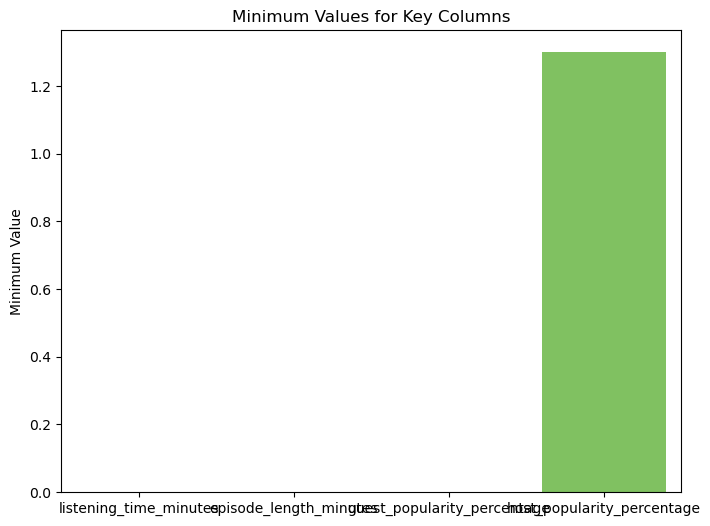

In [69]:
# Visualize minimum values for selected columns
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['listening_time_minutes', 'episode_length_minutes', 'guest_popularity_percentage', 'host_popularity_percentage']
min_values = {col: train_df[col].min() for col in cols}

plt.figure(figsize=(8,6))
sns.barplot(x=list(min_values.keys()), y=list(min_values.values()), palette="viridis")
plt.ylabel('Minimum Value')
plt.title('Minimum Values for Key Columns')
plt.show()

In [70]:
# Function to remove outliers using the IQR method for each column
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply outlier removal for each relevant column
for col in cols:
    train_df = remove_outliers(train_df, col)

# Optionally, review the updated summary statistics
train_df.describe()

,id,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes
count,749999.000000,749999.000000,749999.000000,749999.000000,749999.000000,749999.000000
mean,374999.864484,64.502042,59.859913,52.233515,1.348857,45.437381
std,216506.409521,31.000001,22.873110,25.534154,1.151129,27.138315
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187500.500000,39.420000,39.410000,34.550000,0.000000,23.178350
50%,375000.000000,64.423470,60.050000,52.431959,1.000000,43.379460
75%,562499.500000,90.310000,79.530000,71.040000,2.000000,64.811580
max,749999.000000,120.930000,119.460000,119.910000,103.910000,119.970000


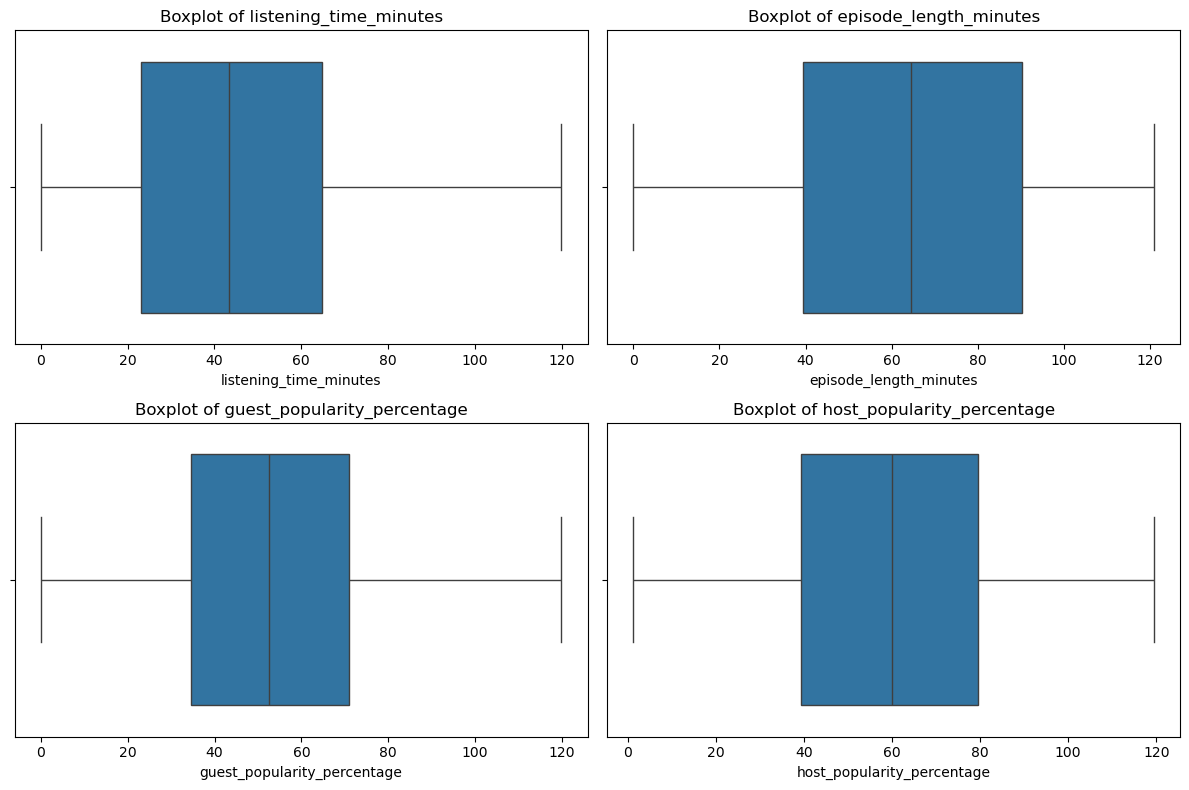

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['listening_time_minutes', 'episode_length_minutes', 'guest_popularity_percentage', 'host_popularity_percentage']

fig, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x=train_df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [72]:
# Define the columns where 0 is not acceptable
cols_to_filter = ['listening_time_minutes', 'episode_length_minutes', 'guest_popularity_percentage', 'host_popularity_percentage']

# Filter out rows that have 0 in any of these columns
for col in cols_to_filter:
    train_df = train_df[train_df[col] > 0]

# Check the new summary statistics
train_df.describe()

,id,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes
count,741446.000000,741446.000000,741446.000000,741446.000000,741446.000000,741446.000000
mean,374958.712042,65.104233,59.836725,52.308894,1.348356,45.961493
std,216506.923437,30.617316,22.874275,25.602945,1.152668,26.849507
min,0.000000,1.240000,1.300000,0.010000,0.000000,0.000560
25%,187432.250000,40.220000,39.380000,34.550000,0.000000,23.875150
50%,374927.500000,64.526115,60.020000,52.507648,1.000000,43.815260
75%,562461.750000,90.750000,79.500000,71.180000,2.000000,65.073730
max,749999.000000,120.930000,119.460000,119.910000,103.910000,119.970000


i want to treat the popularity and mintues col separately, the outliers I want to get rid of for the popularity are anything outside Q2 and for the mintues cols I want to look at the rati

In [73]:
# Remove outliers in the popularity columns, keeping rows only when the value is between Q1 and Q3.
pop_cols = ['guest_popularity_percentage', 'host_popularity_percentage']
for col in pop_cols:
    Q1 = train_df[col].quantile(0.10)
    Q3 = train_df[col].quantile(0.90)
    # keep rows in which the value is between Q1 and Q3 (i.e. only the middle 50%)
    train_df = train_df[(train_df[col] >= Q1) & (train_df[col] <= Q3)]
    
# Optionally review the popularity columns summary
train_df[pop_cols].describe()

,guest_popularity_percentage,host_popularity_percentage
count,474644.000000,474644.000000
mean,52.811394,59.664943
std,18.451057,18.306950
min,14.040000,28.400000
25%,41.530000,43.800000
50%,52.507648,59.900000
75%,65.560000,75.790000
max,88.460000,91.460000


In [74]:
train_df.describe()

,id,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,number_of_ads,listening_time_minutes
count,474644.000000,474644.000000,474644.000000,474644.000000,474644.000000,474644.000000
mean,374989.909667,64.937790,59.664943,52.811394,1.360712,45.597546
std,216500.271341,30.553211,18.306950,18.451057,1.161233,26.716980
min,0.000000,1.240000,28.400000,14.040000,0.000000,0.000560
25%,187335.500000,40.200000,43.800000,41.530000,0.000000,23.554050
50%,375069.000000,64.526115,59.900000,52.507648,1.000000,43.498220
75%,562349.250000,90.270000,75.790000,65.560000,2.000000,64.660000
max,749997.000000,120.930000,91.460000,88.460000,103.910000,119.970000


In [75]:
# List of columns to encode
cols_to_encode = ['episode_sentiment', 'publication_day', 'genre', 'publication_time']
encoders = {}

for col in cols_to_encode:
    le = LabelEncoder()
    # Convert to string in case of any non-string values and fit on train data
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    # Transform test data using the same encoder
    test_df[col] = le.transform(test_df[col].astype(str))
    encoders[col] = le

# Optionally, display the transformed columns from train_df
train_df[cols_to_encode].head()

,episode_sentiment,publication_day,genre,publication_time
0,2,4,9,3
1,0,2,1,0
3,2,1,8,2
4,1,1,3,0
5,2,2,3,0


In [76]:
#Drop id, podcast_name, episode_title from train and test
train_df = train_df.drop(columns=['id', 'podcast_name', 'episode_title', 'number_of_ads', 'publication_time', 'episode_sentiment', 'publication_day', 'genre'])
test_df = test_df.drop(columns=['id', 'podcast_name', 'episode_title', 'number_of_ads', 'publication_time', 'episode_sentiment', 'publication_day', 'genre'])

In [77]:
test_df.head()

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage
0,78.96,38.11,53.330000
1,27.87,71.29,51.985752
2,69.10,67.89,97.510000
3,115.39,23.40,51.750000
4,72.32,58.10,11.300000


In [78]:
train_df.head()

,episode_length_minutes,host_popularity_percentage,guest_popularity_percentage,listening_time_minutes
0,64.388461,74.81,52.241037,31.41998
1,119.800000,66.95,75.950000,88.01241
3,67.170000,57.22,78.700000,46.27824
4,110.510000,80.07,58.680000,75.61031
5,26.540000,48.96,51.341545,22.77047


In [79]:
# Define the target
target = 'listening_time_minutes'

# For training data: drop the target column, fit and transform the features, then add the target back
X_train = train_df.drop(columns=[target])
X_test = test_df

In [80]:
# Scale the features in the training and test sets
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [81]:
# Define the target
target = 'listening_time_minutes'

# Separate the target variable from the training and test datasets
y_train = train_df[target]
# Check if the target column exists in test_df
if target in test_df.columns:
	y_test = test_df[target]
else:
	# If the target column is missing, create it with placeholder values (e.g., NaN)
	y_test = pd.Series([None] * len(test_df), name=target)

# Apply PCA
# Adjust n_components to be less than or equal to the number of features
n_components = min(X_train_scaled.shape[1], 7)  # 7 is the number of features in the dataset
pca = PCA(n_components=n_components) 
X_train_pca = pca.fit_transform(X_train_scaled) 
X_test_pca = pca.transform(X_test_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Create DataFrames with the principal components
pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
train_pca_df[target] = y_train.reset_index(drop=True)

test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)
test_pca_df[target] = y_test.reset_index(drop=True)

# Save the DataFrames with principal components to CSV files
train_pca_df.to_csv('/Users/blairjdaniel/kaggle_comps/kaggle_predict_podcast/processed/train_pca.csv', index=False)
test_pca_df.to_csv('/Users/blairjdaniel/kaggle_comps/kaggle_predict_podcast/processed/test_pca.csv', index=False)

# Print the shapes of the DataFrames to verify
print("Shape of train_pca_df:", train_pca_df.shape)
print("Shape of test_pca_df:", test_pca_df.shape)


Explained Variance Ratio: [0.34039093 0.33895086 0.32065822]
Shape of train_pca_df: (474644, 4)
Shape of test_pca_df: (250000, 4)


In [82]:
print("Original training set shape:", X_train.shape) 
print("Training set shape after scaling:", X_train_scaled.shape) 
print("Training set shape after PCA:", X_train_pca.shape)

Original training set shape: (474644, 3)
Training set shape after scaling: (474644, 3)
Training set shape after PCA: (474644, 3)
